# LSTM Travel Time + Speed Prediction - N101.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.2')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6395,86,17,2021042800
6409,86,17,2021042800
6423,86,17,2021042800
6437,86,17,2021042800
6451,86,17,2021042800
...,...,...,...
294406,86,17,2021051509
294420,86,17,2021051509
294434,86,17,2021051509
294448,86,17,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,86.000000,17.000000
2021042801,86.000000,17.000000
2021042802,86.000000,17.000000
2021042803,86.000000,17.000000
2021042804,86.000000,17.000000
...,...,...
2021051505,75.941176,19.882353
2021051506,84.705882,17.411765
2021051507,86.000000,17.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed



,currentSpeed
timeStamp,
2021042800,0.974174
2021042801,0.974174
2021042802,0.974174
2021042803,0.974174
2021042804,0.974174
...,...
2021051505,0.714398
2021051506,0.940753
2021051507,0.974174


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 5s 672ms/step - loss: 0.7382 - mae: 0.7334 - rmse: 0.6535 - val_loss: 7.6650e-04 - val_mae: 7.6650e-04 - val_rmse: 7.6650e-04
Epoch 2/300
3/3 [==============================] - 0s 56ms/step - loss: 0.0019 - mae: 0.0014 - rmse: 0.0018 - val_loss: 3.7971e-04 - val_mae: 3.7971e-04 - val_rmse: 3.7971e-04
Epoch 3/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0015 - mae: 0.0011 - rmse: 0.0014 - val_loss: 2.1741e-04 - val_mae: 2.1741e-04 - val_rmse: 2.1741e-04
Epoch 4/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0013 - mae: 7.2088e-04 - rmse: 0.0012 - val_loss: 1.6871e-04 - val_mae: 1.6871e-04 - val_rmse: 1.6871e-04
Epoch 5/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0016 - mae: 8.2415e-04 - rmse: 0.0015 - val_loss: 9.9566e-05 - val_mae: 9.9566e-05 - val_rmse: 9.9566e-05
Epoch 6/300
3/3 [==============================] - 0s 56ms/step - loss: 0.0014 - mae: 6.4816e-04 - rmse: 0.0013

3/3 [==============================] - 0s 75ms/step - loss: 0.0014 - mae: 4.9791e-04 - rmse: 0.0012 - val_loss: 1.8153e-06 - val_mae: 1.8146e-06 - val_rmse: 1.8153e-06
Epoch 47/300
3/3 [==============================] - 0s 97ms/step - loss: 0.0014 - mae: 4.9770e-04 - rmse: 0.0012 - val_loss: 1.7899e-06 - val_mae: 1.7881e-06 - val_rmse: 1.7899e-06
Epoch 48/300
3/3 [==============================] - 0s 128ms/step - loss: 0.0014 - mae: 4.9326e-04 - rmse: 0.0012 - val_loss: 1.9427e-06 - val_mae: 1.9405e-06 - val_rmse: 1.9427e-06
Epoch 49/300
3/3 [==============================] - 0s 143ms/step - loss: 0.0014 - mae: 4.9391e-04 - rmse: 0.0012 - val_loss: 1.9941e-06 - val_mae: 1.9934e-06 - val_rmse: 1.9941e-06
Epoch 50/300
3/3 [==============================] - 0s 106ms/step - loss: 0.0014 - mae: 4.9583e-04 - rmse: 0.0012 - val_loss: 1.8151e-06 - val_mae: 1.8146e-06 - val_rmse: 1.8151e-06
Epoch 51/300
3/3 [==============================] - 0s 132ms/step - loss: 0.0014 - mae: 4.9747e-04 - rmse

3/3 [==============================] - 0s 87ms/step - loss: 0.0014 - mae: 4.9069e-04 - rmse: 0.0012 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_rmse: 0.0000e+00
Epoch 92/300
3/3 [==============================] - 0s 80ms/step - loss: 0.0014 - mae: 4.9013e-04 - rmse: 0.0012 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_rmse: 0.0000e+00
Epoch 93/300
3/3 [==============================] - 0s 171ms/step - loss: 0.0014 - mae: 4.9078e-04 - rmse: 0.0012 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_rmse: 0.0000e+00
Epoch 94/300
3/3 [==============================] - 0s 118ms/step - loss: 0.0014 - mae: 4.9018e-04 - rmse: 0.0012 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_rmse: 0.0000e+00
Epoch 95/300
3/3 [==============================] - 0s 64ms/step - loss: 0.0014 - mae: 4.9093e-04 - rmse: 0.0012 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_rmse: 0.0000e+00
Epoch 96/300
3/3 [==============================] - 0s 87ms/step - loss: 0.0014 - mae: 4.9014e-04 - rmse: 

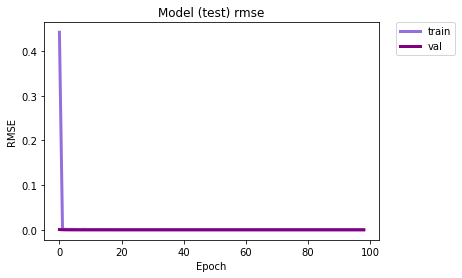

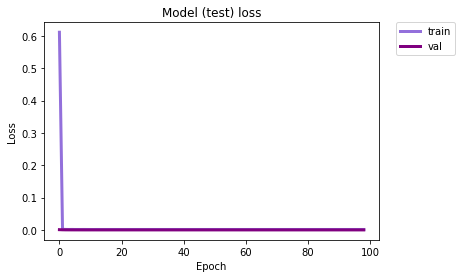

Epoch 1/300
5/5 [==============================] - 0s 68ms/step - loss: 0.0014 - mae: 4.5851e-04 - rmse: 0.0014 - val_loss: 1.8435e-04 - val_mae: 4.4938e-05 - val_rmse: 1.8435e-04
Epoch 2/300
5/5 [==============================] - 0s 60ms/step - loss: 0.0014 - mae: 4.5830e-04 - rmse: 0.0014 - val_loss: 1.8423e-04 - val_mae: 4.5264e-05 - val_rmse: 1.8423e-04
Epoch 3/300
5/5 [==============================] - 0s 79ms/step - loss: 0.0014 - mae: 4.6057e-04 - rmse: 0.0014 - val_loss: 1.8417e-04 - val_mae: 4.5478e-05 - val_rmse: 1.8417e-04
Epoch 4/300
5/5 [==============================] - 0s 77ms/step - loss: 0.0014 - mae: 4.6238e-04 - rmse: 0.0014 - val_loss: 1.8385e-04 - val_mae: 4.6748e-05 - val_rmse: 1.8385e-04
Epoch 5/300
5/5 [==============================] - 0s 77ms/step - loss: 0.0014 - mae: 4.6893e-04 - rmse: 0.0014 - val_loss: 1.8311e-04 - val_mae: 4.9602e-05 - val_rmse: 1.8311e-04
Epoch 6/300
5/5 [==============================] - 1s 119ms/step - loss: 0.0014 - mae: 4.8251e-04 - 

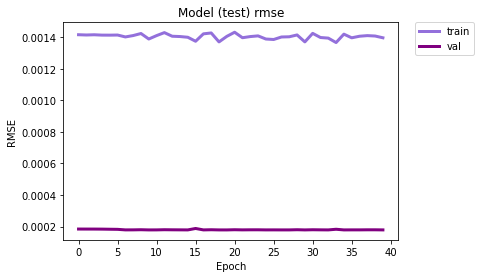

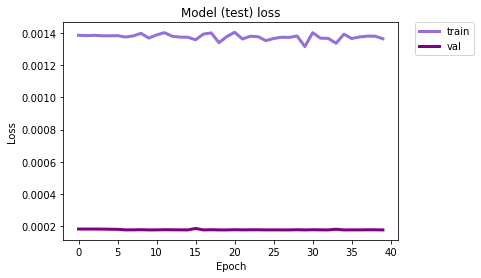

Epoch 1/300
7/7 [==============================] - 0s 56ms/step - loss: 0.0013 - mae: 5.3973e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 2/300
7/7 [==============================] - 0s 62ms/step - loss: 0.0013 - mae: 4.6611e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 3/300
7/7 [==============================] - 0s 60ms/step - loss: 0.0013 - mae: 4.8094e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 4/300
7/7 [==============================] - 1s 70ms/step - loss: 0.0013 - mae: 4.7470e-04 - rmse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0146 - val_rmse: 0.0286
Epoch 5/300
7/7 [==============================] - 1s 78ms/step - loss: 0.0013 - mae: 5.6500e-04 - rmse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 6/300
7/7 [==============================] - 0s 56ms/step - loss: 0.0013 - mae: 5.1485e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse:

7/7 [==============================] - 1s 71ms/step - loss: 0.0013 - mae: 5.1398e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 50/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0013 - mae: 5.1098e-04 - rmse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 51/300
7/7 [==============================] - 0s 51ms/step - loss: 0.0013 - mae: 5.2579e-04 - rmse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0146 - val_rmse: 0.0287
Epoch 52/300
7/7 [==============================] - 0s 51ms/step - loss: 0.0013 - mae: 5.8108e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0146 - val_rmse: 0.0286
Epoch 53/300
7/7 [==============================] - 0s 48ms/step - loss: 0.0013 - mae: 5.4736e-04 - rmse: 0.0016 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286
Epoch 54/300
7/7 [==============================] - 0s 49ms/step - loss: 0.0013 - mae: 5.0864e-04 - rmse: 0.0015 - val_loss: 0.0528 - val_mae: 0.0145 - val_rmse: 0.0286

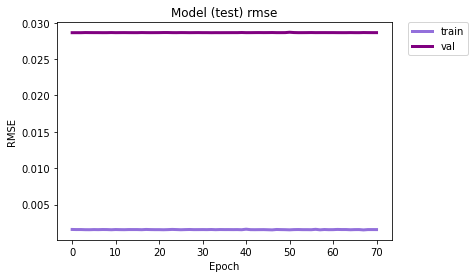

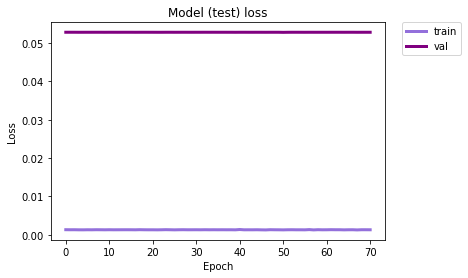

Epoch 1/300
9/9 [==============================] - 0s 53ms/step - loss: 0.0080 - mae: 0.0024 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 2/300
9/9 [==============================] - 0s 48ms/step - loss: 0.0080 - mae: 0.0023 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 3/300
9/9 [==============================] - 0s 51ms/step - loss: 0.0080 - mae: 0.0023 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 4/300
9/9 [==============================] - 0s 52ms/step - loss: 0.0080 - mae: 0.0023 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 5/300
9/9 [==============================] - 0s 48ms/step - loss: 0.0080 - mae: 0.0023 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 6/300
9/9 [==============================] - 0s 48ms/step - loss: 0.0080 - mae: 0.0023 - rmse: 0.0074 - val_loss: 0.0095 - val_mae: 0.0033 - val_rmse: 0.0124
Epoch 7/300
9/9 

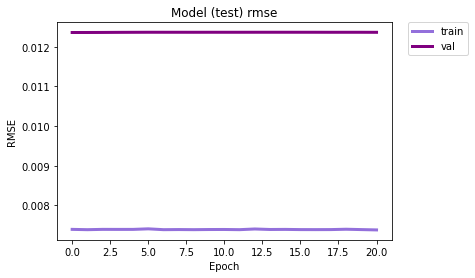

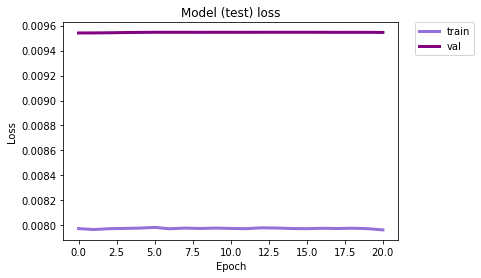

Epoch 1/300
11/11 [==============================] - 1s 50ms/step - loss: 0.0079 - mae: 0.0023 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 2/300
11/11 [==============================] - 1s 46ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 3/300
11/11 [==============================] - 0s 45ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 4/300
11/11 [==============================] - 1s 50ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 5/300
11/11 [==============================] - 1s 50ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 6/300
11/11 [==============================] - 1s 49ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoc

11/11 [==============================] - 1s 46ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 51/300
11/11 [==============================] - 0s 45ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 52/300
11/11 [==============================] - 1s 49ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 53/300
11/11 [==============================] - 1s 49ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0040 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 54/300
11/11 [==============================] - 0s 44ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0075 - val_loss: 0.0040 - val_mae: 0.0015 - val_rmse: 0.0038
Epoch 55/300
11/11 [==============================] - 0s 46ms/step - loss: 0.0079 - mae: 0.0024 - rmse: 0.0076 - val_loss: 0.0041 - val_mae: 0.0014 - val_rmse: 0.0038
Epoch 56/30

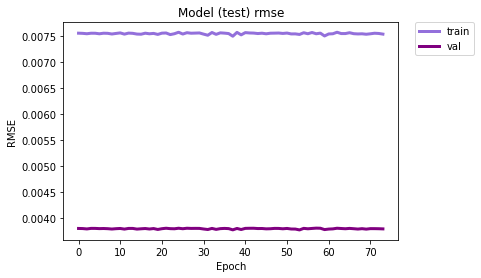

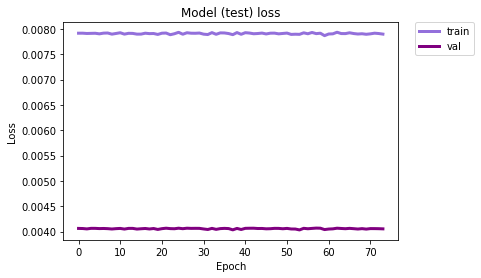

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9997054
Transformed yhat 9.5691
yhat -0.99971575
Transformed yhat 9.568699
yhat -0.9997258
Transformed yhat 9.568309
yhat -0.999736
Transformed yhat 9.567914
yhat -0.99981034
Transformed yhat 9.565037
yhat -0.99982315
Transformed yhat 9.56454
yhat -0.9998232
Transformed yhat 9.564538
yhat -0.99982315
Transformed yhat 9.56454
yhat -0.99982315
Transformed yhat 9.56454
yhat -0.9998232
Transformed yhat 9.564538
yhat -0.9998232
Transformed yhat 9.564538
yhat -0.9998232
Transformed yhat 9.564538
Real data: [ 9.63605434  9.55769231  9.55769231 87.         27.20265428  9.55769231
  9.55769231  9.6838479   9.55769231  9.55769231  9.58292343  9.61543275
  9.55769231  9.55769231  9.55769231  9.55769231  9.55769231  9.55769231
  9.55769231 10.1758547   9.64600122  9.55769231  9.55769231  9.55769231]
Forecasting values: [9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6]


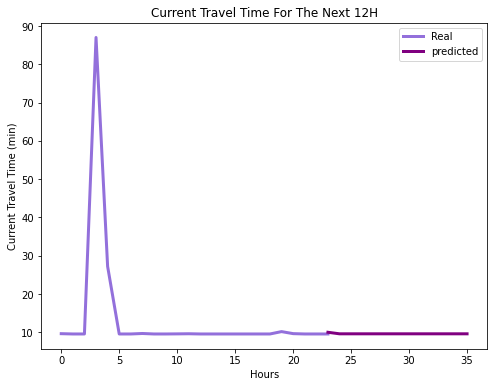

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.2',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 6s 554ms/step - loss: 0.6934 - mae: 0.6888 - rmse: 0.6164 - val_loss: 0.0254 - val_mae: 0.0254 - val_rmse: 0.0254
Epoch 2/300
3/3 [==============================] - 0s 73ms/step - loss: 0.0265 - mae: 0.0130 - rmse: 0.0264 - val_loss: 0.0252 - val_mae: 0.0252 - val_rmse: 0.0252
Epoch 3/300
3/3 [==============================] - 0s 78ms/step - loss: 0.0263 - mae: 0.0131 - rmse: 0.0262 - val_loss: 0.0249 - val_mae: 0.0249 - val_rmse: 0.0249
Epoch 4/300
3/3 [==============================] - 0s 81ms/step - loss: 0.0260 - mae: 0.0131 - rmse: 0.0255 - val_loss: 0.0236 - val_mae: 0.0236 - val_rmse: 0.0236
Epoch 5/300
3/3 [==============================] - 0s 78ms/step - loss: 0.0256 - mae: 0.0145 - rmse: 0.0253 - val_loss: 0.0205 - val_mae: 0.0205 - val_rmse: 0.0205
Epoch 6/300
3/3 [==============================] - 0s 79ms/step - loss: 0.0236 - mae: 0.0157 - rmse: 0.0236 - val_loss: 0.0205 - val_mae: 0.0205 - val_rmse: 0.0205
Epoch 7/300
3/3

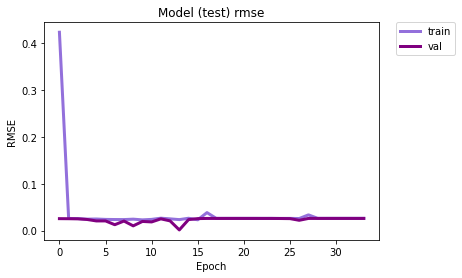

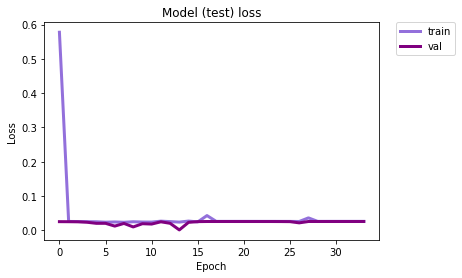

Epoch 1/300
5/5 [==============================] - 0s 78ms/step - loss: 0.0298 - mae: 0.0226 - rmse: 0.0301 - val_loss: 0.0155 - val_mae: 0.0145 - val_rmse: 0.0155
Epoch 2/300
5/5 [==============================] - 0s 60ms/step - loss: 0.0269 - mae: 0.0186 - rmse: 0.0282 - val_loss: 0.0167 - val_mae: 0.0155 - val_rmse: 0.0167
Epoch 3/300
5/5 [==============================] - 0s 69ms/step - loss: 0.0250 - mae: 0.0176 - rmse: 0.0259 - val_loss: 0.0144 - val_mae: 0.0136 - val_rmse: 0.0144
Epoch 4/300
5/5 [==============================] - 0s 65ms/step - loss: 0.0267 - mae: 0.0195 - rmse: 0.0274 - val_loss: 0.0157 - val_mae: 0.0147 - val_rmse: 0.0157
Epoch 5/300
5/5 [==============================] - 0s 62ms/step - loss: 0.0270 - mae: 0.0192 - rmse: 0.0285 - val_loss: 0.0180 - val_mae: 0.0166 - val_rmse: 0.0180
Epoch 6/300
5/5 [==============================] - 0s 61ms/step - loss: 0.0265 - mae: 0.0188 - rmse: 0.0284 - val_loss: 0.0190 - val_mae: 0.0174 - val_rmse: 0.0190
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 89ms/step - loss: 0.0257 - mae: 0.0176 - rmse: 0.0265 - val_loss: 0.0141 - val_mae: 0.0134 - val_rmse: 0.0141
Epoch 52/300
5/5 [==============================] - 0s 71ms/step - loss: 0.0252 - mae: 0.0178 - rmse: 0.0265 - val_loss: 0.0158 - val_mae: 0.0147 - val_rmse: 0.0158
Epoch 53/300
5/5 [==============================] - 0s 66ms/step - loss: 0.0259 - mae: 0.0179 - rmse: 0.0265 - val_loss: 0.0140 - val_mae: 0.0133 - val_rmse: 0.0140
Epoch 54/300
5/5 [==============================] - 0s 69ms/step - loss: 0.0254 - mae: 0.0177 - rmse: 0.0262 - val_loss: 0.0128 - val_mae: 0.0123 - val_rmse: 0.0128
Epoch 55/300
5/5 [==============================] - 0s 79ms/step - loss: 0.0260 - mae: 0.0196 - rmse: 0.0275 - val_loss: 0.0161 - val_mae: 0.0151 - val_rmse: 0.0161
Epoch 56/300
5/5 [==============================] - 0s 71ms/step - loss: 0.0253 - mae: 0.0175 - rmse: 0.0251 - val_loss: 0.0154 - val_mae: 0.0144 - val_rmse: 0.0154
Epoch 57/3

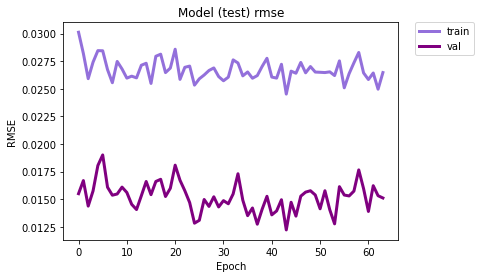

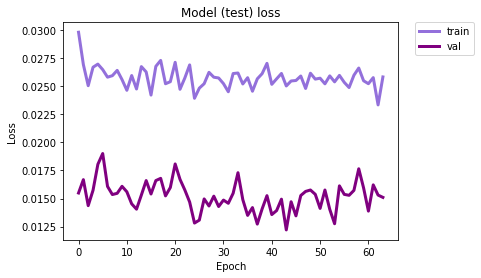

Epoch 1/300
7/7 [==============================] - 0s 73ms/step - loss: 0.0257 - mae: 0.0184 - rmse: 0.0289 - val_loss: 0.2780 - val_mae: 0.0898 - val_rmse: 0.1613
Epoch 2/300
7/7 [==============================] - 0s 64ms/step - loss: 0.0252 - mae: 0.0183 - rmse: 0.0284 - val_loss: 0.2776 - val_mae: 0.0911 - val_rmse: 0.1632
Epoch 3/300
7/7 [==============================] - 1s 75ms/step - loss: 0.0269 - mae: 0.0199 - rmse: 0.0300 - val_loss: 0.2782 - val_mae: 0.0892 - val_rmse: 0.1604
Epoch 4/300
7/7 [==============================] - 1s 79ms/step - loss: 0.0267 - mae: 0.0195 - rmse: 0.0300 - val_loss: 0.2782 - val_mae: 0.0893 - val_rmse: 0.1604
Epoch 5/300
7/7 [==============================] - 0s 65ms/step - loss: 0.0262 - mae: 0.0189 - rmse: 0.0291 - val_loss: 0.2779 - val_mae: 0.0900 - val_rmse: 0.1615
Epoch 6/300
7/7 [==============================] - 1s 76ms/step - loss: 0.0251 - mae: 0.0179 - rmse: 0.0284 - val_loss: 0.2780 - val_mae: 0.0899 - val_rmse: 0.1614
Epoch 7/300
7/7 

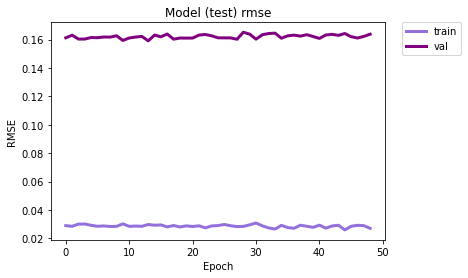

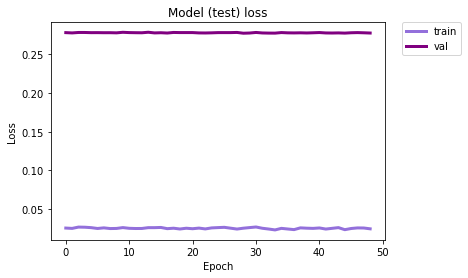

Epoch 1/300
9/9 [==============================] - 1s 66ms/step - loss: 0.0570 - mae: 0.0278 - rmse: 0.0539 - val_loss: 0.0829 - val_mae: 0.0365 - val_rmse: 0.0941
Epoch 2/300
9/9 [==============================] - 1s 61ms/step - loss: 0.0576 - mae: 0.0273 - rmse: 0.0540 - val_loss: 0.0814 - val_mae: 0.0338 - val_rmse: 0.0925
Epoch 3/300
9/9 [==============================] - 1s 63ms/step - loss: 0.0582 - mae: 0.0277 - rmse: 0.0546 - val_loss: 0.0808 - val_mae: 0.0326 - val_rmse: 0.0919
Epoch 4/300
9/9 [==============================] - 1s 64ms/step - loss: 0.0583 - mae: 0.0279 - rmse: 0.0551 - val_loss: 0.0818 - val_mae: 0.0346 - val_rmse: 0.0930
Epoch 5/300
9/9 [==============================] - 1s 74ms/step - loss: 0.0567 - mae: 0.0267 - rmse: 0.0532 - val_loss: 0.0800 - val_mae: 0.0309 - val_rmse: 0.0910
Epoch 6/300
9/9 [==============================] - 1s 66ms/step - loss: 0.0593 - mae: 0.0279 - rmse: 0.0558 - val_loss: 0.0826 - val_mae: 0.0361 - val_rmse: 0.0938
Epoch 7/300
9/9 

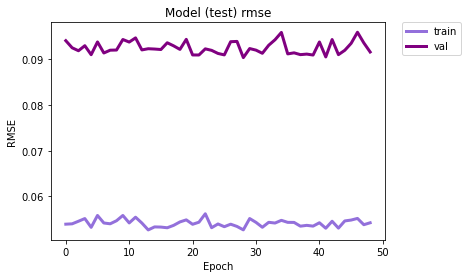

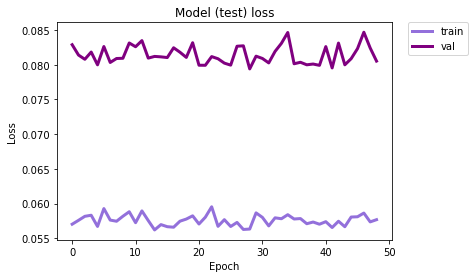

Epoch 1/300
11/11 [==============================] - 1s 81ms/step - loss: 0.0596 - mae: 0.0292 - rmse: 0.0578 - val_loss: 0.0600 - val_mae: 0.0296 - val_rmse: 0.0565
Epoch 2/300
11/11 [==============================] - 1s 94ms/step - loss: 0.0577 - mae: 0.0277 - rmse: 0.0561 - val_loss: 0.0603 - val_mae: 0.0305 - val_rmse: 0.0568
Epoch 3/300
11/11 [==============================] - 1s 104ms/step - loss: 0.0579 - mae: 0.0278 - rmse: 0.0564 - val_loss: 0.0603 - val_mae: 0.0307 - val_rmse: 0.0569
Epoch 4/300
11/11 [==============================] - 1s 103ms/step - loss: 0.0578 - mae: 0.0284 - rmse: 0.0558 - val_loss: 0.0600 - val_mae: 0.0296 - val_rmse: 0.0565
Epoch 5/300
11/11 [==============================] - 1s 108ms/step - loss: 0.0584 - mae: 0.0281 - rmse: 0.0571 - val_loss: 0.0597 - val_mae: 0.0287 - val_rmse: 0.0561
Epoch 6/300
11/11 [==============================] - 1s 114ms/step - loss: 0.0572 - mae: 0.0273 - rmse: 0.0557 - val_loss: 0.0601 - val_mae: 0.0300 - val_rmse: 0.0566


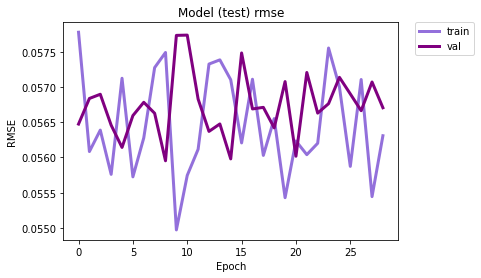

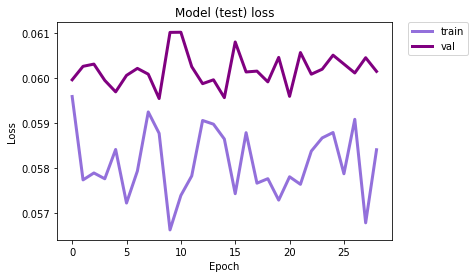

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.98521465
Transformed yhat 86.42749
yhat 0.9855702
Transformed yhat 86.44126
yhat 0.98590815
Transformed yhat 86.454346
yhat 0.9862309
Transformed yhat 86.46685
yhat 0.98706913
Transformed yhat 86.4993
yhat 0.9875229
Transformed yhat 86.51688
yhat 0.9876315
Transformed yhat 86.52108
yhat 0.9877392
Transformed yhat 86.52525
yhat 0.9878604
Transformed yhat 86.52994
yhat 0.9879603
Transformed yhat 86.533806
yhat 0.9880519
Transformed yhat 86.53735
yhat 0.9881344
Transformed yhat 86.54055
Real data: [85.76923077 87.         87.          9.55769231 43.31372549 87.
 87.         84.11764706 86.         86.         86.09803922 85.32692308
 86.         86.         86.         86.         86.         86.
 86.         75.94117647 84.70588235 86.         86.         86.        ]
Forecasting values: [86.4, 86.4, 86.5, 86.5, 86.5, 86.5, 86.5, 86.5, 86.5, 86.5, 86.5, 86.5]


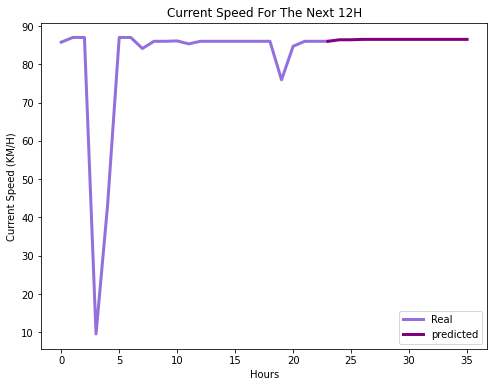

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.2',forecastSpeed[i],hour[i]
        writer.writerow(d)
